Código para la implementación del array con los 7 canales
#Regresión

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

TensorFlow version: 2.18.0
Num GPUs Available: 1
Sun Jul  6 02:38:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |

In [ ]:
#Esto sirve para usar los archivos que están en el drive
#(más rápido que subirlos manualmente)
from google.colab import drive
# Montar Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Import modules
import numpy as np
import pandas as pd
import random
import cv2

import tensorflow as tf
import albumentations as albu

from tensorflow.keras.models import Sequential
from tensorflow.keras import models, Model, layers, losses, optimizers, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB3

In [ ]:
#Leer archivos
import openpyxl
df = pd.read_excel("/content/drive/MyDrive/Colab/Albers/Arreglos y bases/2020/Base_Albers_Final_81k.xlsx")
y_ref = np.array(df["Coneval_2020"])

print(np.shape(y_ref))
print(np.min(y_ref), np.max(y_ref), np.var(y_ref))

(81428,)
0.0545095096 0.996466762 0.038181904293514514


In [ ]:
# Leer imágenes
x_imgs = np.load("/content/drive/MyDrive/Colab/Albers/Arreglos y bases/2020/Arreglos/7bandas_final_81k.npy")
print(np.shape(x_imgs), np.min(x_imgs), np.max(x_imgs), np.mean(x_imgs))

|
x_imgs[x_imgs<0.0] = 0.0
x_imgs[x_imgs==-9999] = 0.0
x_imgs[x_imgs== 65535] = 0.0


print(np.shape(x_imgs), np.min(x_imgs), np.max(x_imgs), np.mean(x_imgs))
#scale intensity values
scale = 1.0 / 10000.0
x_imgs = scale * x_imgs
print(np.shape(y_ref))
print(np.min(y_ref), np.max(y_ref), np.var(y_ref))

(81428, 7, 40, 40) -9999 65535 1535.9834751526764
(81428, 7, 40, 40) 0 20073 1523.6433507482948
(81428,)
0.0545095096 0.996466762 0.038181904293514514


In [ ]:
# Swap de canales
x_imgs = np.swapaxes(x_imgs, 1, 3)
x_imgs = np.swapaxes(x_imgs, 1, 2)

print(np.shape(x_imgs))
print(np.min(x_imgs), np.max(x_imgs), np.mean(x_imgs))

(81428, 40, 40, 7)
0.0 2.0073000000000003 0.1523643350748296


In [ ]:
# Crear particiones
random.seed(123)
nrec = len(y_ref)
ntrain = int(0.5 * nrec)
nval = int(0.2 * nrec)

# Índices de partición
ind = np.arange(0, nrec)
random.shuffle(ind)
ind_train = ind[0:ntrain]
ind_val = ind[ntrain:ntrain + nval]
ind_test = ind[ntrain + nval:nrec]

# Partición de imágenes
x_train = x_imgs[ind_train]
x_val = x_imgs[ind_val]
x_test = x_imgs[ind_test]

# Partición de datos
y_train = y_ref[ind_train]
y_val = y_ref[ind_val]
y_test = y_ref[ind_test]

#repeat training data
#repeats = 15 #Seguir probando
#x_train = np.repeat(x_train, repeats, axis=0)
#y_train = np.repeat(y_train, repeats, axis=0)



print(np.shape(x_train), np.shape(x_val), np.shape(x_test))
print(np.shape(y_train), np.shape(y_val), np.shape(y_test))

(40714, 40, 40, 7) (16285, 40, 40, 7) (24429, 40, 40, 7)
(40714,) (16285,) (24429,)


In [ ]:
###EfficientNetB3

height, width, channels = 224, 224, 6

cnn_source = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(height, width, 3))

conv_base= EfficientNetB3(weights=None, include_top=False, input_shape=(height, width, 7))

#copy weights of the trained model to the new model adding regularization
penalty = 0.1
regularizer = tf.keras.regularizers.l2(penalty)

for i in np.arange(5,len(conv_base.layers)):
    layer_source = cnn_source.get_layer(index=i+1)
    layer_dest = conv_base.get_layer(index=i)
    w = layer_source.get_weights()
    layer_dest.set_weights(w)
    for attr in ['kernel_regularizer']:
        if hasattr(layer_dest, attr):
            setattr(layer_dest, attr, regularizer)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/applications/efficientnet.py:289: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 7 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [ ]:
# Construir el modelo final
model = Sequential()
model.add( conv_base )
model.add( GlobalAveragePooling2D() )
model.add( Dropout(0.5) )
model.add( Dense(1, activation='sigmoid') )

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,784,983 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,786,520 (41.15 MB)

 Trainable params: 10,699,209 (40.81 MB)

 Non-trainable params: 87,311 (341.06 KB)

In [ ]:
batch_size = 32

def resize_img(img, shape):
    return cv2.resize(img, (int(shape[1]), int(shape[0])), interpolation=cv2.INTER_CUBIC)

#==============================================================
#data generator for training and validation

In [ ]:
random.seed(123)
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size=batch_size, dim=(height, width), channels=channels, augment=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.indexes = np.arange(0, len(self.x))
        self.augment = augment

    def __on_epoch_end(self):
        self.indexes = np.arange(0, len(self.x))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx+1) * self.batch_size]

        #generate mini-batch of X
        scale_dim = 1.6
        X = []
        for i, ID in enumerate(batch_indexes):
            img = self.x[ID]
            img = resize_img(img, (scale_dim*self.dim[0], scale_dim*self.dim[1]))
            X.append(img)
        X = np.array(X)

        #generate mini-batch of y
        y = self.y[batch_indexes]

        #augmentation on the training dataset
        if self.augment==True:
            X = self.__augment_batch(X)

        #crop images to the size of 224 x 224 pixels
        sz = np.shape(X)
        h_off = int(0.5 * (sz[1] - self.dim[0]))
        w_off = int(0.5 * (sz[2] - self.dim[1]))
        X = X[:, h_off:h_off+self.dim[0], w_off:w_off+self.dim[1], :]
        return X, y

    #augmentation for one image
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                    albu.VerticalFlip(p=0.5),
                                    albu.GridDistortion(p=0.2),
                                    albu.ElasticTransform(p=0.2),
                                    albu.Rotate(p=1)])
        return composition(image=img)['image']

    #augmentation for batch of images
    def __augment_batch(self, img_batch):
        for i in np.arange(0, len(img_batch)):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch

train_gen = DataGenerator(x_train, y_train, augment=True)
val_gen = DataGenerator(x_val, y_val, augment=False)
test_gen = DataGenerator(x_test, y_test, augment = False) #Agregado 7 marzo de 2025

In [ ]:
# Compilar el modelo
learning_rate = 1.0e-4
mse = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, restore_best_weights=True )
rlrop = ReduceLROnPlateau(monitor="val_loss", mode="min", patience=3, factor=0.5, min_lr=1e-6, verbose=1)

model.compile(optimizer=opt, loss=mse)
# Entrenar el modelo
epochs = 30
res = model.fit(train_gen, validation_data=val_gen, callbacks=[early_stop, rlrop], epochs=epochs, verbose=1)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1546s 1s/step - loss: 0.0308 - val_loss: 0.0221 - learning_rate: 1.0000e-04
Epoch 2/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1367s 1s/step - loss: 0.0214 - val_loss: 0.0218 - learning_rate: 1.0000e-04
Epoch 3/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1337s 1s/step - loss: 0.0194 - val_loss: 0.0220 - learning_rate: 1.0000e-04
Epoch 4/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1306s 1s/step - loss: 0.0181 - val_loss: 0.0177 - learning_rate: 1.0000e-04
Epoch 5/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1300s 1s/step - loss: 0.0169 - val_loss: 0.0169 - learning_rate: 1.0000e-04
Epoch 6/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1356s 1s/step - loss: 0.0157 - val_loss: 0.0223 - learning_rate: 1.0000e-04
Epoch 7/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1308s 1s/step - loss: 0.0149 - val_loss: 0.0174 - learning_rate: 1.0000e-04
Epoch 8/30
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - loss: 0.0141
Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1273/1273 ━━━━━━━━━━━━━━━━━

In [ ]:
# Guardar historial de entrenamiento
filename = "training_history_EfficientNetB3_7B_NN_SC_Coneval_2020_Norp_03062025_model.csv"
train_loss = res.history["loss"]
val_loss = res.history["val_loss"]
df = pd.DataFrame({"train_loss": train_loss, "val_loss": val_loss})
df.to_csv(filename)

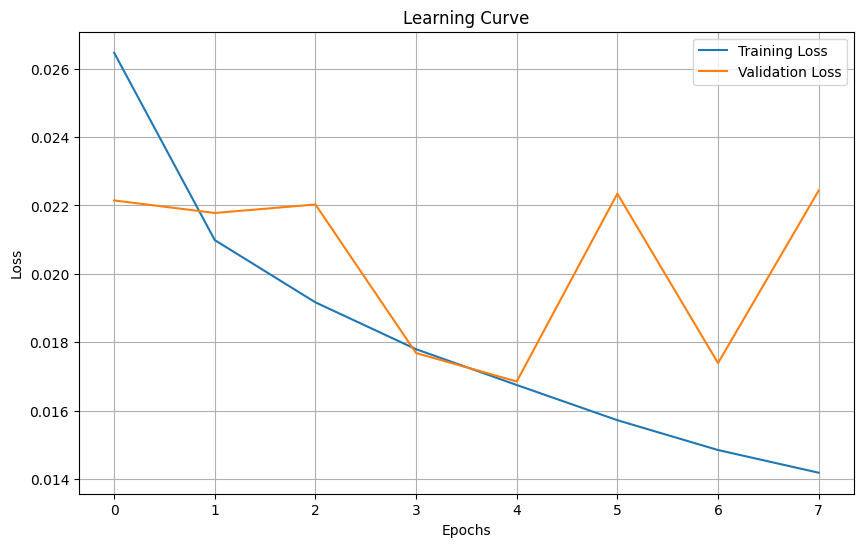

In [ ]:
import matplotlib.pyplot as plt

#historial de entrenamiento
train_loss = res.history["loss"]
val_loss = res.history["val_loss"]

# gráfica
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Guardar modelo entrenado
model.save('model_EfficientNetB3_7B_NN_SC_Coneval_2020_Albers_Norp_03062025_b.h5')
print('Model saved - ok')

Model saved - ok


In [ ]:
#Predicción
height, width, channels = (224, 224, 7)

def compute_predictions(model):
	ns = 20
	y_pred = []
	for i in np.arange(0, len(x_test), ns):
		if( i % 50000 == 0.0 ):
			print(' %d%%' % int(100.0*i/len(x_test)), end='')
		imax = np.min((i+ns, len(x_test)))
		xt = []
		for j in np.arange(i, imax):
			xr = cv2.resize(x_test[j], (width,height), interpolation=cv2.INTER_CUBIC)
			xt.append(xr)
		xt = np.array(xt)
		yp = model.predict(xt)
		for j in np.arange(0, len(yp)):
			y_pred.append(yp[j])
	print('')
	return np.array(y_pred).ravel()

In [ ]:
#Chunk con el que se evaluo en resnet50v2
#evaluate model
print('Results for model:')

filename = 'model_EfficientNetB3_7B_NN_SC_Coneval_2020_Albers_Norp_03062025_b.h5'
model = models.load_model(filename)
y_pred = model.predict(test_gen)

# Reshape y_pred to be 1-dimensional
y_pred = y_pred.ravel() # or y_pred = y_pred.reshape(-1)

filename = 'predictions_regressionEfnb3_NN_SC_Coneval_2020_norp_albers_final_03062025.csv'
df = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})
df.to_csv(filename)


#y_pred = compute_predictions(model)
y_pred= np.array(y_pred)
mse = np.mean((y_pred - y_test)**2.0)
sigma2 = np.mean((y_test - np.mean(y_test))**2.0)
R2 = 1.0 - mse/sigma2

print('  R^2 = %0.4f' % R2)
print('  mse = %0.4f' % mse)

Results for model:


764/764 ━━━━━━━━━━━━━━━━━━━━ 220s 279ms/step
  R^2 = 0.5572
  mse = 0.0169


In [ ]:
from google.colab import files
files.download('model_EfficientNetB3_7B_NN_SC_Coneval_2020_Albers_Norp_03062025_b.h5')
files.download("training_history_EfficientNetB3_7B_NN_SC_Coneval_2020_Norp_03062025_model.csv")
files.download("predictions_regressionEfnb3_NN_SC_Coneval_2020_norp_albers_final_03062025.csv")

#Código de Pablo Vera con el que hizo predicciones

In [ ]:
#function to resize and crop an image
height, width = (224, 224)
scale_dim = 1.6
def resize_img(img, height, width, scale_dim):
    wd, hg = (int(scale_dim*width), int(scale_dim*height))
    img_res = cv2.resize(img, (wd, hg), interpolation=cv2.INTER_CUBIC)
    h_off = int(0.5 * (hg - height))
    w_off = int(0.5 * (wd - width))
    img_res = img_res[h_off:h_off+height, w_off:w_off+width, :]
    return img_res

In [ ]:
#compute predictions
nsel = 100
ntest = len(x_test)
y_pred = []
for i in np.arange(0,ntest,nsel):
    if( i % 2000 == 0 ):
        print(i, ' - ', ntest)
    imax = np.min((i+nsel,ntest))
    xt = []
    for j in np.arange(i,imax):
        imr = resize_img(x_test[j], height, width, scale_dim)
        xt.append(imr)
    xt = np.array(xt)
    yp = model.predict(xt, verbose=0)
    for j in np.arange(0,len(yp)):
        y_pred.append(yp[j,0])

print(np.shape(y_pred))

0  -  24429


In [ ]:
#save predictions to a csv file
filename = 'predictions2_regressionEfnb3_7B_NN_SC_Coneval_2020_Norp_03062025_2.csv'

df = pd.DataFrame({'ind_test':ind_test,
                   'y_test':y_test,
                   'y_pred':y_pred})

df.to_csv(filename, mode='w', index=False, header=True)

In [ ]:
#compute R^2
mse = np.mean((y_pred - y_test)**2.0)
sigma2 = np.mean((y_test - np.mean(y_test))**2.0)
R2 = 1.0 - mse/sigma2

print(f'MSE = {mse:0.4f}')
print(f'R^2 = {R2:0.4f}')

In [ ]:
#compute correlation
r = np.corrcoef(y_pred, y_test)

print(r)

In [ ]:
from google.colab import files
files.download("predictions2_regressionEfnb3_7B_NN_SC_Coneval_2020_Norp_03062025_2.csv")

In [ ]:
from tensorflow.keras import models
import pandas as pd
import numpy as np
import cv2

height, width = 224, 224
scale_dim = 1.6

# Función auxiliar
def resize_img(img, height, width, scale_dim):
    wd, hg = (int(scale_dim*width), int(scale_dim*height))
    img_res = cv2.resize(img, (wd, hg), interpolation=cv2.INTER_CUBIC)
    h_off = int(0.5 * (hg - height))
    w_off = int(0.5 * (wd - width))
    img_res = img_res[h_off:h_off+height, w_off:w_off+width, :]
    return img_res

# Leer identificadores
df_base = pd.read_excel("/content/drive/MyDrive/Colab/Albers/Arreglos y bases/Base_Albers_Final_81k.xlsx",
                        usecols=["CVEGEO", "CVE_ENT", "CVE_MUN", "CVE_LOC", "CVE_AGEB", "Coneval_2020"])

# Predecir para todos los datos
n_total = len(x_imgs)
batch_size_pred = 100
y_pred_all = []

for i in range(0, n_total, batch_size_pred):
    print(f"Procesando {i}/{n_total}")
    i_max = min(i + batch_size_pred, n_total)
    xt = [resize_img(x_imgs[j], height, width, scale_dim) for j in range(i, i_max)]
    xt = np.array(xt)
    yp = model.predict(xt, verbose=0)
    y_pred_all.extend(yp[:, 0])

# Agregar predicciones
df_base["y_pred"] = y_pred_all

# Evaluación (opcional, si tienes P_INDEX01)
y_true = df_base["Coneval_2020"].values
mse = np.mean((y_pred_all - y_true) ** 2)
sigma2 = np.mean((y_true - np.mean(y_true)) ** 2)
R2 = 1.0 - mse / sigma2

print("Resultados en base completa:")
print(f"  R^2 = {R2:.4f}")
print(f"  MSE  = {mse:.4f}")

# Guardar predicciones con identificadores
df_base.to_csv("predicciones_completas_NN_SC_Coneval_2020_noRP_03062025con_ids_.csv", index=False)

In [ ]:
from google.colab import files
files.download("predicciones_completas_NN_SC_Coneval_2020_noRP_03062025con_ids_.csv")